#### t-SNE: T-Distributed Stochastic Neighbor Embedding Explained
- https://learnopencv.com/t-sne-t-distributed-stochastic-neighbor-embedding-explained/
- https://distill.pub/2016/misread-tsne/

학습 목표
- t-SNE (t-distributed Stochastic Neighbor Embedding) 이해 및 사용법
- SKLearn에서 PCA, t-SNE 사용법
- PCA/t-SNE 차이
- t-SNE의 확률적 성격
- tensorboard에서의 사용

<목차>
1. t-SNE (t-distributed Stochastic Neighbor Embedding) 개요
2. t-SNE 내부 동작
3. 2D -> 1D 임베딩(t-SNE / PCA) 예시 및 고찰
4. Perplexity 값에 대한 고찰
5. Tensorboard 사용

##### 1. t-SNE (t-distributed Stochastic Neighbor Embedding) 개요
- t-SNE는 고차원 특징을 2/3차원 공간에 시각화 하는 기능이다.
- Laurens van der Maaten, Geoffrey Hinton에 의해 2008에 소개
- `t-SNE는 점의 상대적 포지션을 저차원 공간에서도 유지(preserve)한다`
- `저차원 에서도 가까운 점을 그대로 가까이 위치하면, 먼 점 끼리는 여전히 멀게 위치한다`

##### 2. t-SNE 내부 동작
- 고 차원에서는 점 쌍에 대한 확률 분포가 유사한 점(유클리드 거리, 코사인 유사성)에 높은 확률을 할당하고, 다른 점에는 낮은 확률을 할당하는 방식으로 구성된다.
- `저 차원에서는 높은 차원에서 그랬던 것 처럼 유사한 확률 분포를 달성하려고 시도한다`.
- 이를 달성하려면 두 분포간의 KL-발산을 최소화 해야 한다.
- 따라서, t-SNE은 확률적(Stochastic)이라고 할 수 있다(?)

##### 3. 2D -> 1D 임베딩(t-SNE / PCA) 예시 및 고찰

In [8]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
 
import requests
from zipfile import ZipFile
import os
#import tensorflow as tf
from PIL import Image
 
from tensorboard.plugins import projector

In [4]:
np.random.seed(0)
num_points_per_class = 50
# Class 1
mean1 = [0, 0]
cov = [[0.1, 0], [0, 0.1]]
X1 = np.random.multivariate_normal(mean1, cov, num_points_per_class)
 
# Class 2
mean2 = [10, 0]
X2 = np.random.multivariate_normal(mean2, cov, num_points_per_class)
 
# Class 3
mean3 = [5, 6]
X3 = np.random.multivariate_normal(mean3, cov, num_points_per_class)

X = np.concatenate([X1, X2, X3], axis=0)
X.shape

(150, 2)

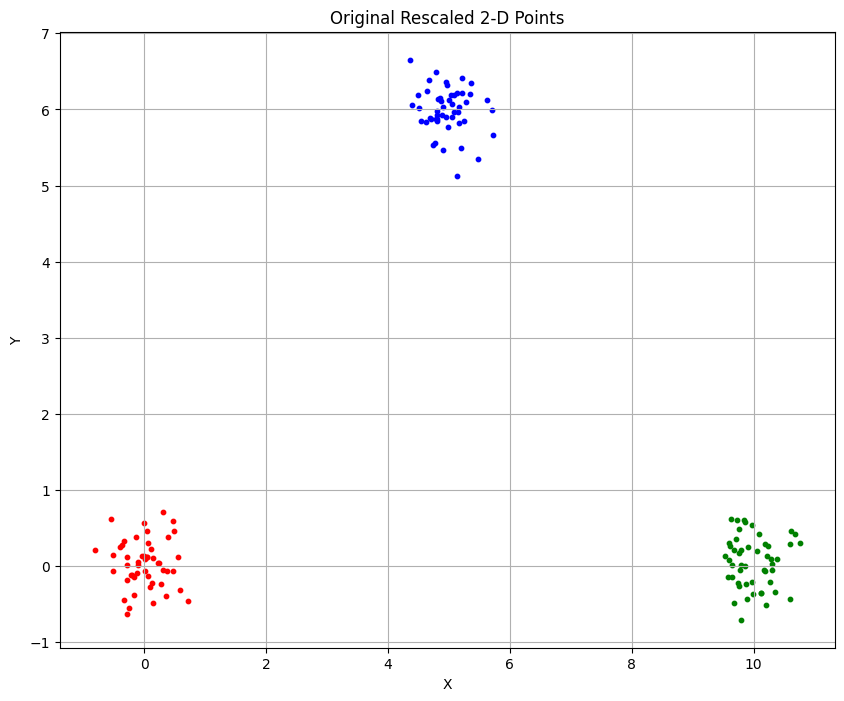

In [6]:
class VisualizeScatter:
    def __init__(self, fig_size=(10, 8), xlabel='X', ylabel='Y', title=None, size=10, num_classes=3):
        plt.figure(figsize=fig_size)
        plt.grid('true')
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

        self.colors = ['red', 'green', 'blue']

        self.num_classes = num_classes
        self.size = size
 
    def add_scatters(self, X):
        x = X[:, 0]

        if X.shape[1] == 2:
            y = X[:, 1]
        else:
            y = np.zeros(len(x))

        points_per_class = len(x) // self.num_classes # 포인트가 순서대로 Concat 되어 있으니

        st = 0
        end = points_per_class
        
        for i in range(self.num_classes):
            plt.scatter(x[st:end], y[st:end], color=self.colors[i % len(self.colors)], s=self.size)
            st = end
            end = end + points_per_class
 
    @staticmethod
    def show_plot():
        plt.show()

vis = VisualizeScatter(fig_size=(10, 8), title="Original Rescaled 2-D Points")
vis.add_scatters(X)
vis.show_plot()

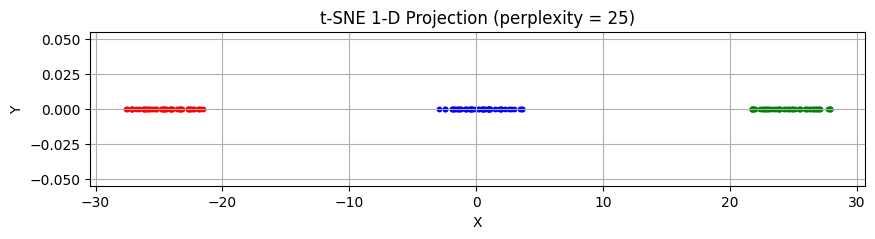

In [7]:
perplexity = 25
X_embedded = TSNE(n_components=1, 
                    perplexity=perplexity, 
                    learning_rate='auto', 
                    init='random', 
                    random_state=0).fit_transform(X)
tsne_vis = VisualizeScatter(fig_size=(10, 2), 
    title='t-SNE 1-D Projection (perplexity = {})'.format(perplexity))
tsne_vis.add_scatters(X_embedded)
tsne_vis.show_plot()

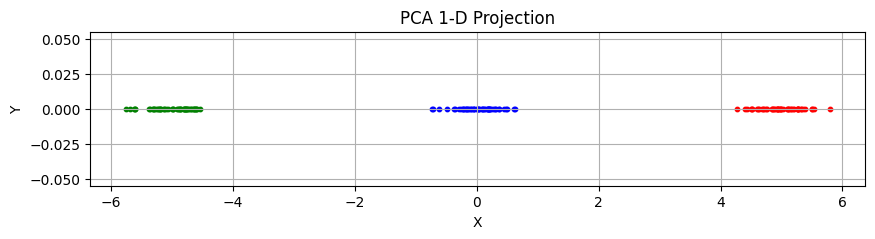

In [10]:
pca = PCA(n_components=1)
X_reduced = pca.fit_transform(X)
pca_vis = VisualizeScatter(fig_size=(10, 2), title='PCA 1-D Projection')
pca_vis.add_scatters(X_reduced)
pca_vis.show_plot()

고찰
- 본인의 (Seed) 값에서는 잘 되었지만, 실제로 PCA는 분포가 오버랩 되는 경우가 발생한다.
- 이는 PCA가 데이터 분포가 저 차원으로 이동하면서 분포 성향(?)이 지켜지지 못하는 탓
- `사유: PCA는 상대 위치를 유지하기 보다 분산을 최대화 하기 위한 것(?)`

##### 4. Perplexity 값에 대한 고찰

- `Perplexity(당혹스러움)은 Maniford 학습 알고리즘에 사용되는 최근접 이웃 수와 관련이 있다`.
- 큰 데이터 셋은 큰 Perplexity를 필요로 한다(?)
- 5~50 사이 값을 선택하는 것이 좋다(?)
- Perplexity는 샘플 수보다 작아야 한다
- `Perplexity가 매우 낮으면, 더 적은 수의 포인트가 가까운 이웃으로 간주 되므로 동일한 클러스터에 속한 포인터라도 흩어진다`.
- `1Perplexity가 매우 높으면, 많은 수의 포인트가 이웃으로 간주되므로 서로 다른 클러스터에 속한 포인트라도 뭉칠 위험이 있다`.

==> 이웃으로 포함할 갯수와 관련이 있다 보다, 디폴트는 30이다.

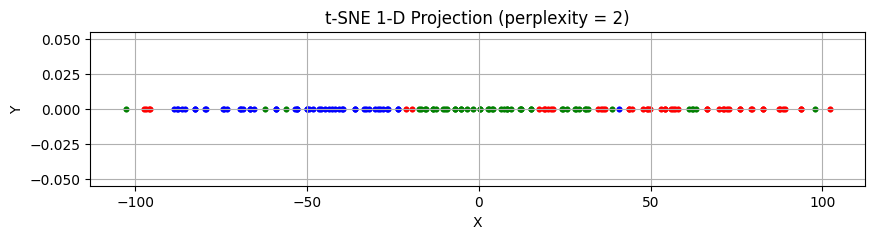

In [12]:
perplexity = 2
X_embedded = TSNE(n_components=1, perplexity=perplexity,  learning_rate='auto',  init='random',  random_state=0).fit_transform(X)
tsne_vis = VisualizeScatter(fig_size=(10, 2), 
    title='t-SNE 1-D Projection (perplexity = {})'.format(perplexity))
tsne_vis.add_scatters(X_embedded)
tsne_vis.add_scatters(X_embedded)
tsne_vis.show_plot()

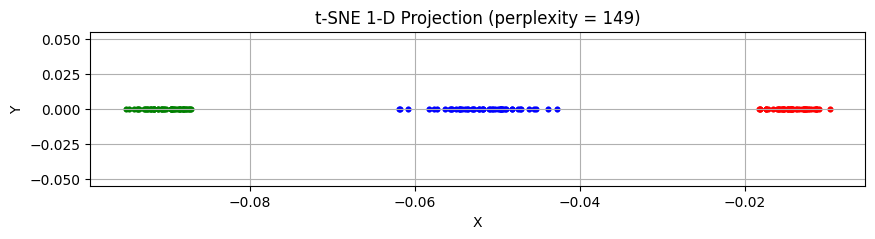

In [16]:
perplexity = 149
X_embedded = TSNE(n_components=1, perplexity=perplexity,  learning_rate='auto',  init='random',  random_state=0).fit_transform(X)
tsne_vis = VisualizeScatter(fig_size=(10, 2), 
    title='t-SNE 1-D Projection (perplexity = {})'.format(perplexity))
tsne_vis.add_scatters(X_embedded)
tsne_vis.add_scatters(X_embedded)
tsne_vis.show_plot()

##### 5. Tensorboard 사용
- 특징 벡터와 라벨, 이미지를 알고 있다고 가정한다.
- 스프라이트(?) 이미지를 생성하고, 텐서보드에 추가하여 텐서보드 프로젝터 구성을 업데이트 한다.
- 3개 파일을 로그 폴더에 쓴다.

In [ ]:
embeddings {
           metadata_path: "metadata.tsv"
           sprite {
                  image_path: "sprite.jpg"
                  single_image_dim: 224
                  single_image_dim: 224
                  }
           tensor_path: "features.tsv"
           }

In [21]:
def get_classwise_image_path(root_dir):
    image_paths = dict()
    classes = os.listdir(root_dir)
    for cls in classes:
        image_paths[cls] = []
        class_dir = os.path.join(root_dir, cls)
        images = os.listdir(class_dir)
        for image_name in images:
            img_path = os.path.join(class_dir, image_name)
            image_paths[cls].append(img_path)
    return image_paths
IMG_ROOT_DIR = './data/animal10'
image_paths_dict = get_classwise_image_path(IMG_ROOT_DIR)
print(len(image_paths_dict))

10


In [1]:
import numpy as np
from sklearn.manifold import TSNE
import plotly.express as px

# 예시 데이터 로드 및 TSNE 변환
X = np.random.rand(100, 5)  # 100개의 샘플, 5개의 특성을 가진 임의의 데이터
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)

# Plotly를 사용하여 인터렉티브한 그래프 생성
fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1])
fig.show()